In [69]:
import pandas as pd
import numpy as np
import re
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import timedelta

In [70]:
# Loading the data from files

# More detailed documentation can be found here:
#        https://mimic.mit.edu/docs/iii/tables/
# Data can be found here:
#        https://physionet.org/content/mimiciii/1.4/
# We are loading 
#        admissions - data from admission of a patient, links to patients on subject_id
#        patients   - data defining a patient, pk is subject_id
#        icustays   - data about one stay in the ICU, links to subject_id
#        procedures - data for each procedure, fk subject_id
#        prescriptions - data about prescription made (perhaps cancelled later), fk subject_id
#        labevents  - data for each lab test done, fk subject id
#        microbiologyvents - data for each microbiology event, fk subject_id

df_admissions = pd.read_csv('data/ADMISSIONS.csv', 
                           usecols=['ROW_ID', 'SUBJECT_ID','INSURANCE','LANGUAGE','RELIGION',
                                    'MARITAL_STATUS','ETHNICITY','EDREGTIME','EDOUTTIME',
                                    'HOSPITAL_EXPIRE_FLAG'])
df_patients = pd.read_csv('data/PATIENTS.csv', 
                          usecols=['SUBJECT_ID', 'GENDER', 'DOB', 'DOD'])
df_icustays = pd.read_csv('data/ICUSTAYS.csv', 
                          usecols=['SUBJECT_ID', 'ICUSTAY_ID', 'LOS'])
#df_procedures = pd.read_csv('data/PROCEDURES_ICD.csv')
df_prescriptions = pd.read_csv('data/PRESCRIPTIONS.csv', 
                               usecols=['ROW_ID','SUBJECT_ID'], 
                               dtype={'ROW_ID': int, 'SUBJECT_ID': int})
df_labevents = pd.read_csv('data/LABEVENTS.csv',
                           usecols=['ROW_ID','SUBJECT_ID'], 
                           dtype={'ROW_ID': int, 'SUBJECT_ID': int})
df_microbiologyevents = pd.read_csv('data/MICROBIOLOGYEVENTS.csv',
                                    usecols=['ROW_ID','SUBJECT_ID'],
                                    dtype={'ROW_ID': int, 'SUBJECT_ID': int})

#column names to lowercase
df_admissions.columns = df_admissions.columns.str.lower()
df_patients.columns = df_patients.columns.str.lower()
df_icustays.columns = df_icustays.columns.str.lower()
#df_procedures.columns = df_procedures.columns.str.lower()
df_prescriptions.columns = df_prescriptions.columns.str.lower()
df_labevents.columns = df_labevents.columns.str.lower()
df_microbiologyevents.columns = df_microbiologyevents.columns.str.lower()

#print(df_microbiologyevents.shape)
#print(df_microbiologyevents.head(25))

In [71]:
# Processing the ADMISSIONS table

# Sorting (ascending, so missing values are last), to minimize data loss
# we keep the first row with subject_id and demographic info
df_demographics = (
    df_admissions
    .drop(columns=['edregtime', 'edouttime', 'hospital_expire_flag'])
    .sort_values(by=['subject_id','insurance','language','religion','marital_status','ethnicity'])
    .groupby('subject_id')
    .first()
    .reset_index()
    .drop(columns=['row_id'])
)

#look at length of stay - admissions table (edouttime - edregtime), average per patient
df_admissions['edregtime']=pd.to_datetime(df_admissions['edregtime'])
df_admissions['edouttime']=pd.to_datetime(df_admissions['edouttime'])
df_admissions['los'] = list(map(lambda d: d/timedelta(days=1), (df_admissions['edouttime']-df_admissions['edregtime'])))
df_los_avg = (
    df_admissions
    .groupby('subject_id')
    .los
    .mean()
    .reset_index()
    .rename(columns={"los": "los_avg_admis"})
)
#add to demographics df
df_demographics = pd.merge(df_demographics, df_los_avg, on="subject_id")

# This column needs to be sorted in descending order to keep 
# the last hospital visit per subject_id
df_expire_sorted = (
    df_admissions
    .loc[:, ['subject_id','hospital_expire_flag']] 
    .sort_values(by=['subject_id','hospital_expire_flag'], ascending=False)
    .groupby('subject_id')
    .first()
    .reset_index()
)

#Merge the demographics and expire df
df_admi = pd.merge(df_demographics, df_expire_sorted, on="subject_id")

#count number of hospital admissions per patient (subject_id)
admission_count = (
    df_admissions
    .groupby('subject_id')
    .count()
    .reset_index()
    .rename(columns={"row_id": "num_admis"})
    .loc[:, ['subject_id', 'num_admis']] 
)

#Merge the admissions count into the df
df_admissions = pd.merge(df_admi, admission_count, on="subject_id")
#print(df_demographics.head(25))

In [72]:
# Processing the PATIENTS table

#calculate age here dod-dob

#merge condensed admissions with the patients df
df = pd.merge(df_admissions, df_patients, on="subject_id") 

#print("Admissions:\n",df_admissions.count(),"\n")
#print("Patients:\n", df_patients.count(),"\n")
#print("Merged:\n", df.count())

In [73]:
# Processing the ICUSTAYS table

#calculate avg icu stay by subject_id
df_los_icu = (
    df_icustays
    .groupby('subject_id')
    .los
    .mean()
    .reset_index()
    .rename(columns={'los': 'los_avg_icu'})
)
#print(df_los_icu.head(25))
#print(len(df_los_icu))

#merge to include in df
df = df.join(df_los_icu.set_index('subject_id'), on='subject_id')

In [74]:
# Processing the PRESCRIPTIONS table

#calculate total num of prescriptions by subject_id
df_num_pres = (
    df_prescriptions
    .groupby('subject_id')
    .count()
    .reset_index()
    .rename(columns={"row_id": "num_pres"})
    .loc[:, ['subject_id', 'num_pres']] 
)
#print(df_num_pres.head(25))
#print(len(df_num_pres))

#merge to include in df
df = df.join(df_num_pres.set_index('subject_id'), on='subject_id')


In [75]:
# Processing the LABEVENTS table

#calculate total num of labs by subject_id
df_num_labs = (
    df_labevents
    .groupby('subject_id')
    .count()
    .reset_index()
    .rename(columns={"row_id": "num_labs"})
    .loc[:, ['subject_id', 'num_labs']] 
)
#print(df_num_labs.head(25))
#print(len(df_num_labs))

#merge to include in df
df = df.join(df_num_labs.set_index('subject_id'), on='subject_id')


In [76]:
# Processing the MICROBIOLOGYEVENTS table

#calculate total num of microbiology labs by subject_id
df_num_microbio_labs = (
    df_microbiologyevents
    .groupby('subject_id')
    .count()
    .reset_index()
    .rename(columns={"row_id": "num_microbio_labs"})
    .loc[:, ['subject_id', 'num_microbio_labs']] 
)
#print(df_num_microbio_labs.head(25))
#print(len(df_num_microbio_labs))

#merge to include in df
df = df.join(df_num_microbio_labs.set_index('subject_id'), on='subject_id')


In [77]:
#df.subject_id.isna()
print(len(df.subject_id.unique()))
print(len(df))
df.head()
#df.describe()
#df.subject_id


46520
46520


,subject_id,insurance,language,religion,marital_status,ethnicity,los_avg_admis,hospital_expire_flag,num_admis,gender,dob,dod,los_avg_icu,num_pres,num_labs,num_microbio_labs
0,2,Private,None,NOT SPECIFIED,None,ASIAN,NaN,0,1,M,2138-07-17 00:00:00,NaN,0.0918,4.0,47.0,1.0
1,3,Medicare,None,CATHOLIC,MARRIED,WHITE,0.09375,0,1,M,2025-04-11 00:00:00,2102-06-14 00:00:00,6.0646,NaN,1716.0,17.0
2,4,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,0.50000,0,1,F,2143-05-12 00:00:00,NaN,1.6785,59.0,1654.0,16.0
3,5,Private,None,BUDDHIST,None,ASIAN,NaN,0,1,M,2103-02-02 00:00:00,NaN,0.0844,NaN,19.0,1.0
4,6,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,0,1,F,2109-06-21 00:00:00,NaN,3.6729,148.0,1220.0,NaN


/tmp/ipykernel_486675/2319776261.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr(method='pearson')


<AxesSubplot: >

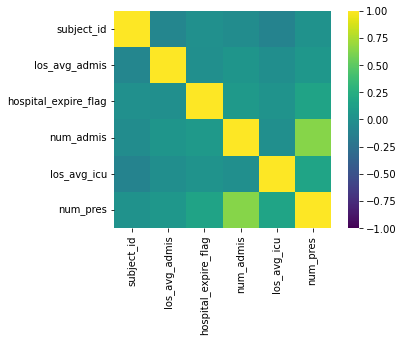

In [48]:

#look at correlation matrix for final dataframe
correlation_matrix = df.corr(method='pearson')
sns.heatmap(correlation_matrix, vmax=1.0, vmin=-1.0,square=True, cmap='viridis')
#correlation_matrix

In [ ]:
#compare avg los, proceduces, etc per group, do anova f_oneway
#stats.f_oneway(los_avg_admis, num_admis, los_avg_icu, num_pres, num_labs, num_microbio_labs)
#compare the 6 factors for the different groups, need a groupby here

#do plots of los, num of tests

In [ ]:
#data cleanup and grouping

df['ethnicity'] = list(map(lambda s: re.sub("UNKNOWN.*|UNABLE.*|PATIENT.*", "OTHER", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("WHITE.*|PORTUGUESE.*", "WHITE", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("ASIAN.*", "ASIAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("BLACK.*", "BLACK", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("HISPANIC.*|AMERICAN.*", "AMERICAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("CARIBBEAN.*|HAWAIIAN.*", "AMERICAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub(".*AMERICAN", "AMERICAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("MULTI.*", "MULTI RACE", s), df['ethnicity']))

df['marital_status'] = df['marital_status'].fillna('UNKNOWN')
df['marital_status'] = list(map(lambda s: re.sub("UNKNOWN.*", "UNKNOWN", s), df['marital_status']))

df['religion'] = df['religion'].fillna('UNKNOWN')
df['religion'] = list(map(lambda s: re.sub("NOT.*|UN.*|OTHER", "UNKNOWN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub("PROT.*|LUTH.*|METHO.*|BAPT.*", "CHRISTIAN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub(".*ORTH.*|.*ADVEN.*|CHRIST.*", "CHRISTIAN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub("EPISCO.*|CATHOLIC|JEHOV.*", "CHRISTIAN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub("HEBREW", "JEWISH", s), df['religion']))

df['language'] = df['language'].fillna('UNKNOWN')
df['language'] = list(map(lambda s: re.sub("\*.*", "OTHER", s), df['language']))
lan_counts = df['language'].value_counts() > 700
df['language'] = list(map(lambda s: s if lan_counts[s] else "OTHER", df['language']))

#print(df['language'].value_counts())
#print(df['language'].unique())


In [ ]:
fig = plt.figure(layout='constrained')
plt.rcParams["figure.figsize"] = (10.5, 8.5)
fig.suptitle('MIMIC III Demographics', fontsize=20)
ax1 = fig.add_subplot(2,3,1)
ax1 = df['insurance'].value_counts().plot(kind='bar')
ax1.set_title('Insurance Type', fontsize = 15)
ax2 = fig.add_subplot(2,3,2)
ax2 = df['ethnicity'].value_counts().plot(kind='bar')
ax2.set_title('Ethnicity', fontsize = 15)
ax3 = fig.add_subplot(2,3,3)
ax3 = df['marital_status'].value_counts().plot(kind='bar')
ax3.set_title('Marital Status', fontsize = 15)
ax4 = fig.add_subplot(2,3,4)
ax4 = df['gender'].value_counts().plot(kind='bar')
ax4.set_title('Gender', fontsize = 15)
ax5 = fig.add_subplot(2,3,5)
ax5 = df['religion'].value_counts().plot(kind='bar')
ax5.set_title('Religion', fontsize = 15)
ax5 = fig.add_subplot(2,3,6)
ax5 = df['language'].value_counts().plot(kind='bar')
ax5.set_title('Language', fontsize = 15)
plt.show()

In [ ]:
#calculate overall mortality rate
mort_rate = df.hospital_expire_flag.mean()

fig = plt.figure(layout='constrained')
fig.suptitle('MIMIC III Hospital Mortality Rate (Overall: '+str(round(mort_rate,2))+')', fontsize=20)
plt.rcParams["figure.figsize"] = (10.5, 8.5)
ax1 = fig.add_subplot(2,3,1)
ax1 = df.groupby('insurance').hospital_expire_flag.mean().plot(kind='bar')
ax1.set_title('by Insurance Type', fontsize = 15)
ax2 = fig.add_subplot(2,3,2)
ax2 = df.groupby('ethnicity').hospital_expire_flag.mean().plot(kind='bar')
ax2.set_title('by Ethnicity', fontsize = 15)
ax3 = fig.add_subplot(2,3,3)
ax3 = df.groupby('marital_status').hospital_expire_flag.mean().plot(kind='bar')
ax3.set_title('by Marital Status', fontsize = 15)
ax4 = fig.add_subplot(2,3,4)
ax4 = df.groupby('gender').hospital_expire_flag.mean().plot(kind='bar')
ax4.set_title('by Gender', fontsize = 15)
ax5 = fig.add_subplot(2,3,5)
ax5 = df.groupby('religion').hospital_expire_flag.mean().plot(kind='bar')
ax5.set_title('by Religion', fontsize = 15)
ax5 = fig.add_subplot(2,3,6)
ax5 = df.groupby('language').hospital_expire_flag.mean().plot(kind='bar')
ax5.set_title('by Language', fontsize = 15)
plt.show()

In [ ]:
#group.size()

#The following code prints out the data that is plotted above
group = df.groupby('insurance')
print(group.hospital_expire_flag.mean())

group = df.groupby('ethnicity')
print(group.hospital_expire_flag.mean())

group = df.groupby('marital_status')
print(group.hospital_expire_flag.mean())

group = df.groupby('gender')
print(group.hospital_expire_flag.mean())

group = df.groupby('religion')
print(group.hospital_expire_flag.mean())

group = df.groupby('language')
print(group.hospital_expire_flag.mean())


In [ ]:
#look at diagnosis for categories - the documentation said that one should not 
# try to stratify data on this field, so didn't do this

# Future work would include:
#num of procedures - procedures_icd table
#look at age groups - do if more time
#long term mortality - do if more time
#      create new plot for long term mortalities, different for different groups?
# look at 50s, white male. How many are alive long term? Is it less?